**Introduction**
The aim of this notebook is to classify patients with different types of thyroid related disease given their age, sex, and medical information – including test results for thyroid hormone levels in blood. The data was obtained from this UCI machine learning repository. The repository contains several text files with different subsets of the data. One of them contains information for ~9000 unique patients along with a medical diagnosis out of 20 possible classes. Those classes make up 7 distinct diagnosis types:

- negative diagnosis
- hyperthyroid conditions
- hypothyroid conditions
- binding protein
- non-thyroidal
- undergoing replacement therapy
- discordant results
The different target diagnoses were mapped to one of these classes at the moment import to the notebook. Some inconclusive diagnoses were dropped given that they make up less than 3% of all cases present in the dataset.

Moving forward with the analysis it has been decided to only keep the observations for patients with diagnosis either negative, hyperthyroid, or hypothyroid. This is because they are the most prevalent observations and the focus of this project. The other classes were dropped from the dataset upon import and thus we are left with ~7500 unique entries in the dataset.

The main reason for dropping the other classes is that they are not important to our focus because either they dont relate thyroid disease per-se (for example non-thyroidal, discordant results), or they refer to a treatment (for example undergoing replacement therapy).
Another big, probably more important, reason is that they create niose in our data.
Our most important attributes are the blood test results of hormone levels. The other target classes referring to treatments and other conditions blurr barriers between classes. We believe they belong in a different analysis with a slightly different focus.

**Preliminary Research**

Before beginning our analysis, it is important to understand the subject and nature of our data.

**What is Thyroid Disease?**
**What is TSH measurement? What are scientifically established normal values?**

- A high TSH level indicates that the thyroid gland is not making enough thyroid hormone (primary hypothyroidism). On the other hand, a low TSH level usually indicates that the thyroid is producing too much thyroid hormone (hyperthyroidism).
- TSH normal values are 0.5 to 5.0 mIU/L

**What is T3 measurement? What are scientifically established normal values?**

- A Total T3 test measures the bound and free fractions of triiodothyronine. Hyperthyroid patients typically have an elevated Total T3 level. T3 tests can be used to support a diagnosis of hyperthyroidism and can determine the severity hyperthyroidism.
- A normal Total T3 level in adults ranges from 80-220 ng/dL

**What is TT4 measurement? What are scientifically established normal values?**

- A Total T4 test measures the bound and free thyroxine (T4) hormone in the blood. Total T4 levels are affected by medications and medical conditions that change thyroid hormone binding proteins. Estrogen, oral contraceptive pills, pregnancy, liver disease, and hepatitis C virus infection are common causes of increased thyroid hormone binding proteins and will result in a high Total T4. Oppositely, Testosterone or androgens and anabolic steroids are common causes of decreased thyroid hormone binding proteins and will result in a low Total T4.
- A normal Total T4 level in adults ranges from 5.0 to 12.0μg/dL

**What is T4U measurement? What are scientifically established normal values?**

- T4U tests measure thyroxine (T4) utilization rate in the body. They can help measure how well the body is utilizing T4 hormone.

**What is FTI measurement? What are scientifically established normal values?**

- A Free T4 Index measures what is not bound and able to freely enter and affect the body tissues. Tests measuring free T4 index (FTI) usually more accurately reflect how the thyroid gland is functioning.
- FT4 normal values are 0.7 to 1.9ng/dL

We do not know the units that the different hormone blood measurements in our dataset use. But knowing about what these levels are usually for individuals can help us tremendously in understanding our dataset. As well as making hypothesis of the units that are used in the dataset and detecting Outliers/inconsistencies.

Now that we have this information, let us begin with the analysis.

In [1]:
import numpy as np
import pandas as pd
import requests
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.stats import zscore
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split

In [2]:
## download data
url = "https://archive.ics.uci.edu/static/public/102/thyroid+disease.zip"
response = requests.get(url)
filename = url.split("/")[-1]
with open(filename , "wb") as f:
    f.write(response.content)
print("Successfully Downloaded")

Successfully Downloaded


In [3]:
## Extract zip file
# make dirs
os.makedirs("data",exist_ok=True)
# create a ZipFile object with zipfile.ZipFile(file_path, 'r') as zip_ref:
with zipfile.ZipFile(filename, 'r') as zip_ref:
    # extract all the contents
    zip_ref.extract("thyroid0387.data","data")

print("Successfully unzipped")

Successfully unzipped


In [4]:
data_path = os.path.join("data","thyroid0387.data")
names = ["age","sex","on_thyroxine","query_on_thyroxine","on_antihyroid_meds","sick","pregnant","thyroid_surgery","I131_treatment","query_hypothyroid","query hyperthyroid","lithium","goitre","tumor","hypopituitary","psych","TSH_measured","TSH","T3_measured","T3","TT4_measured","TT4","T4U_measured","T4U","FTI_measured","FTI","TBG_measured","TBG","referral_source","target"]
df = pd.read_csv(data_path,names=names)

In [5]:
# tidy the target column
df['patient_id'] = df["target"].apply(lambda x: x.split("[")[1].strip(']'))
df['target'] = df["target"].apply(lambda x: x.split("[")[0])

In [6]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antihyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,...,?,f,?,f,?,f,?,other,-,840801013
1,29,F,f,f,f,f,f,f,f,f,...,128,f,?,f,?,f,?,other,-,840801014
2,41,F,f,f,f,f,f,f,f,f,...,?,f,?,f,?,t,11,other,-,840801042
3,36,F,f,f,f,f,f,f,f,f,...,?,f,?,f,?,t,26,other,-,840803046
4,32,F,f,f,f,f,f,f,f,f,...,?,f,?,f,?,t,36,other,S,840803047


In [7]:
# replacing ? with np.nan
df.replace({"?":np.nan},inplace=True)

In [8]:
# converting object to float
num_cols = ["TSH","T3","TT4","T4U","FTI","TBG"]
for i in num_cols:
    df[i] = df[i].astype(float)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9172 entries, 0 to 9171
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 9172 non-null   int64  
 1   sex                 8865 non-null   object 
 2   on_thyroxine        9172 non-null   object 
 3   query_on_thyroxine  9172 non-null   object 
 4   on_antihyroid_meds  9172 non-null   object 
 5   sick                9172 non-null   object 
 6   pregnant            9172 non-null   object 
 7   thyroid_surgery     9172 non-null   object 
 8   I131_treatment      9172 non-null   object 
 9   query_hypothyroid   9172 non-null   object 
 10  query hyperthyroid  9172 non-null   object 
 11  lithium             9172 non-null   object 
 12  goitre              9172 non-null   object 
 13  tumor               9172 non-null   object 
 14  hypopituitary       9172 non-null   object 
 15  psych               9172 non-null   object 
 16  TSH_me

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,9172.0,73.555822,1183.976718,1.000,37.00,55.00,68.000,65526.00
TSH,8330.0,5.218403,24.184006,0.005,0.46,1.40,2.700,530.00
T3,6568.0,1.970629,0.887579,0.050,1.50,1.90,2.300,18.00
TT4,8730.0,108.700305,37.522670,2.000,87.00,104.00,126.000,600.00
T4U,8363.0,0.976056,0.200360,0.170,0.86,0.96,1.065,2.33
FTI,8370.0,113.640746,41.551650,1.400,93.00,109.00,128.000,881.00
TBG,349.0,29.870057,21.080504,0.100,21.00,26.00,31.000,200.00


In [11]:
# age cannot be 65526 
# capping age to 100 years
df = df[df["age"] <= 100]

In [12]:
# Central Tendency
pd.concat([df.describe().T[["mean","50%"]],df.select_dtypes(exclude='object').mode().T[0].to_frame()],axis=1).rename(columns={"50%":"median",0:"mode"})

,mean,median,mode
age,52.099695,55.00,60.00
TSH,5.220548,1.40,0.10
T3,1.970494,1.90,1.80
TT4,108.695698,104.00,101.00
T4U,0.976036,0.96,0.96
FTI,113.638900,109.00,107.00
TBG,29.870057,26.00,24.00


In [13]:
# Measures of dispersion
std = df.describe().T[["std"]]
var = df.select_dtypes(exclude="object").var().to_frame().rename(columns={0:"variance"})
range = (df.describe().T["max"] - df.describe().T["min"]).to_frame().rename(columns={0:"range"})
pd.concat([std,var,range],axis=1)

,std,variance,range
age,18.910296,357.599310,96.000
TSH,24.189614,585.137422,529.995
T3,0.887722,0.788051,17.950
TT4,37.530264,1408.520749,598.000
T4U,0.200392,0.040157,2.160
FTI,41.560437,1727.269956,879.600
TBG,21.080504,444.387643,199.900


In [14]:
# Skeweness
df.select_dtypes(exclude='object').skew().to_frame().rename(columns={0:"skeweness"})

,skeweness
age,-0.223298
TSH,12.920450
T3,2.955359
TT4,1.451832
T4U,1.099862
FTI,3.957114
TBG,4.417312


In [15]:
# kurtosis
df.select_dtypes(exclude='object').kurt().to_frame().rename(columns={0:"kurtosis"})

,kurtosis
age,-0.878807
TSH,211.350688
T3,29.144755
TT4,9.450104
T4U,4.045673
FTI,46.904478
TBG,25.851313


In [16]:
# Duplicates
df.duplicated().sum()

0

## Feature cleaning

In [17]:
# Remove reduntant columns
df.drop(['TSH_measured','T3_measured','TT4_measured','T4U_measured','FTI_measured','TBG_measured','referral_source','patient_id'],axis=1, inplace=True)

['-' 'S' 'F' 'AK' 'R' 'I' 'M' 'N' 'G' 'K' 'A' 'KJ' 'L' 'MK' 'Q' 'J' 'C|I'
 'O' 'LJ' 'H|K' 'D' 'GK' 'MI' 'P' 'FK' 'B' 'GI' 'C' 'GKJ' 'OI' 'D|R' 'E']


<Axes: xlabel='target'>

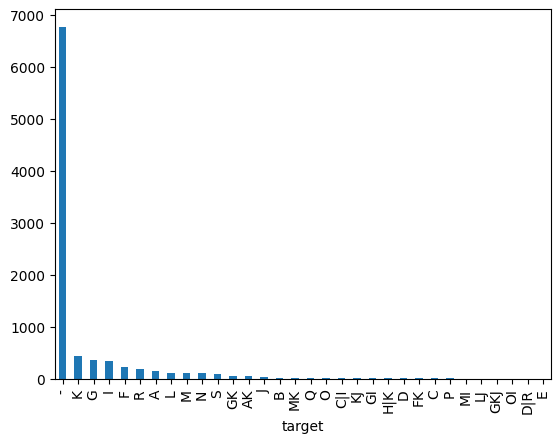

In [18]:
# refining target column
print(df["target"].unique())
df["target"].value_counts().plot(kind="bar")

In [19]:
# Selecting a subset of target which can be classified as Hyper , hypo or Euthyroid (Negative) state
df = df[df['target'].isin(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'AK', 'C|I', 'H|K', 'GK', 'FK', 'GI', 'GKJ', 'D|R', '-'])]

In [20]:
df.shape

(7675, 23)

In [21]:
# mapping the target column
mapping = {'-':"Negative",
           'A':'Hyperthyroid','AK':"Hyperthyroid",'B':"Hyperthyroid", 'C':"Hyperthyroid", 'C|I': 'Hyperthyroid', 'D':"Hyperthyroid", 'D|R':"Hyperthyroid",
           'E': "Hypothyroid", 'F': "Hypothyroid", 'FK': "Hypothyroid", "G": "Hypothyroid", "GK": "Hypothyroid", "GI": "Hypothyroid", 'GKJ': 'Hypothyroid', 'H|K': 'Hypothyroid',
          }
df['target'] = df['target'].map(mapping)

In [22]:
df["target"].unique()

array(['Negative', 'Hypothyroid', 'Hyperthyroid'], dtype=object)

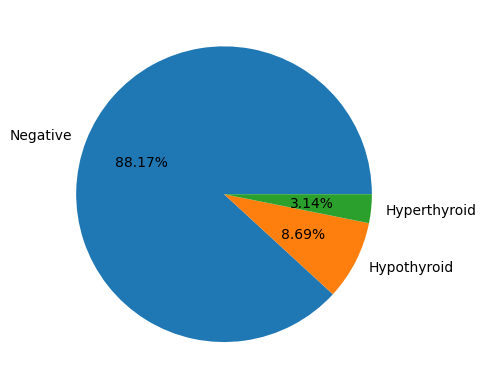

In [23]:
# percentage of classes in target
target = df["target"].value_counts()
plt.pie(target,autopct="%.2f%%",labels=target.index)
plt.show()

<Axes: >

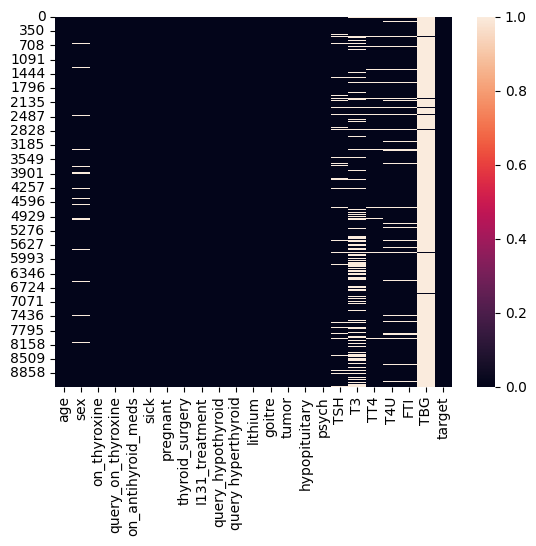

In [24]:
# missing values
sns.heatmap(df.isnull())

In [25]:
# percentage missing 
round(df.isnull().sum()/len(df)*100,2)

age                    0.00
sex                    3.31
on_thyroxine           0.00
query_on_thyroxine     0.00
on_antihyroid_meds     0.00
sick                   0.00
pregnant               0.00
thyroid_surgery        0.00
I131_treatment         0.00
query_hypothyroid      0.00
query hyperthyroid     0.00
lithium                0.00
goitre                 0.00
tumor                  0.00
hypopituitary          0.00
psych                  0.00
TSH                    9.43
T3                    28.77
TT4                    4.61
T4U                    8.87
FTI                    8.78
TBG                   96.63
target                 0.00
dtype: float64

In [26]:
# TBG has entire data missing so it will be dropped
df.drop("TBG",axis=1,inplace=True)

In [27]:
df["sex"].isnull().sum()

254

In [28]:
# impute some missing values of sex (total = 254 missing) using pregnancy
df["sex"] = np.where((df["sex"].isnull()) & (df["pregnant"]=="t"),'F',df["sex"])

In [29]:
# Mapping sex to 0 for female and 1 for male
df["sex"] = df["sex"].map({"F":0,"M":1})

In [30]:
num_cols = df.select_dtypes(exclude="object").columns

In [31]:
df[num_cols].isnull().sum()

age       0
sex     252
TSH     724
T3     2208
TT4     354
T4U     681
FTI     674
dtype: int64

In [32]:
# imputer
imputer = IterativeImputer()
impute_df = imputer.fit_transform(df[num_cols])
impute_df =  pd.DataFrame(impute_df,index=df[num_cols].index , columns=num_cols)
df.update(impute_df)

In [33]:
df["target"].value_counts()/len(df)*100

target
Negative        88.169381
Hypothyroid      8.690554
Hyperthyroid     3.140065
Name: count, dtype: float64

In [34]:
# EDA 
cat_cols = df.select_dtypes(include="object").columns
cat_cols =  cat_cols.drop("target")
num_cols = df.select_dtypes(exclude="object").columns

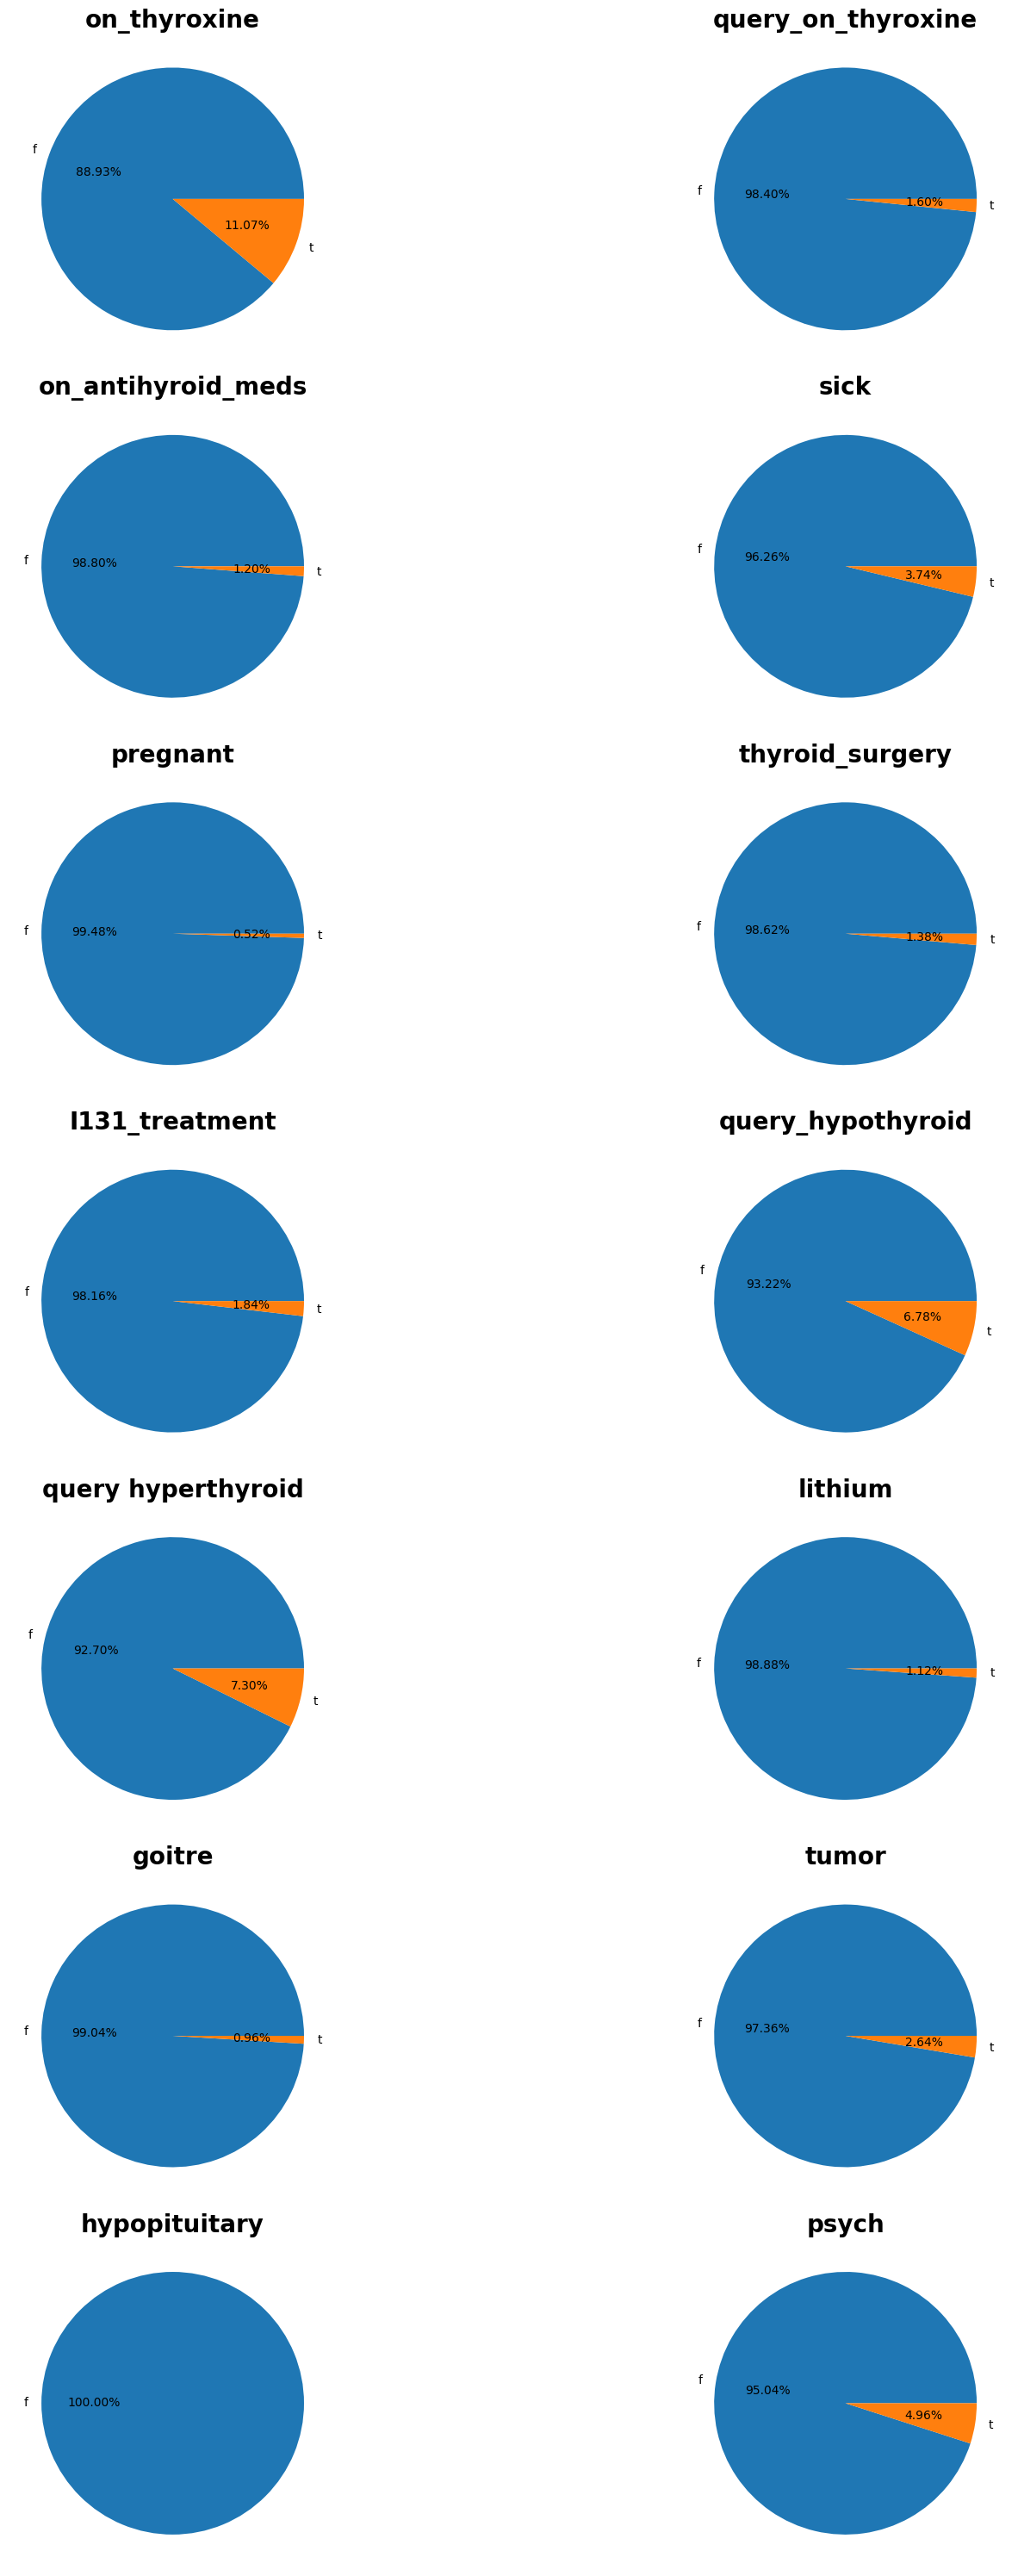

In [35]:
# Categorical columns
fig , ax = plt.subplots(ncols=2,nrows=7,figsize=(20,30))
ax = ax.flatten()
for a,i in enumerate(cat_cols):
    data = df[i].value_counts()
    ax[a].pie(x=data,labels=data.index,autopct="%.2f%%")
    ax[a].set_title(i,size=20,weight="bold")
plt.tight_layout()

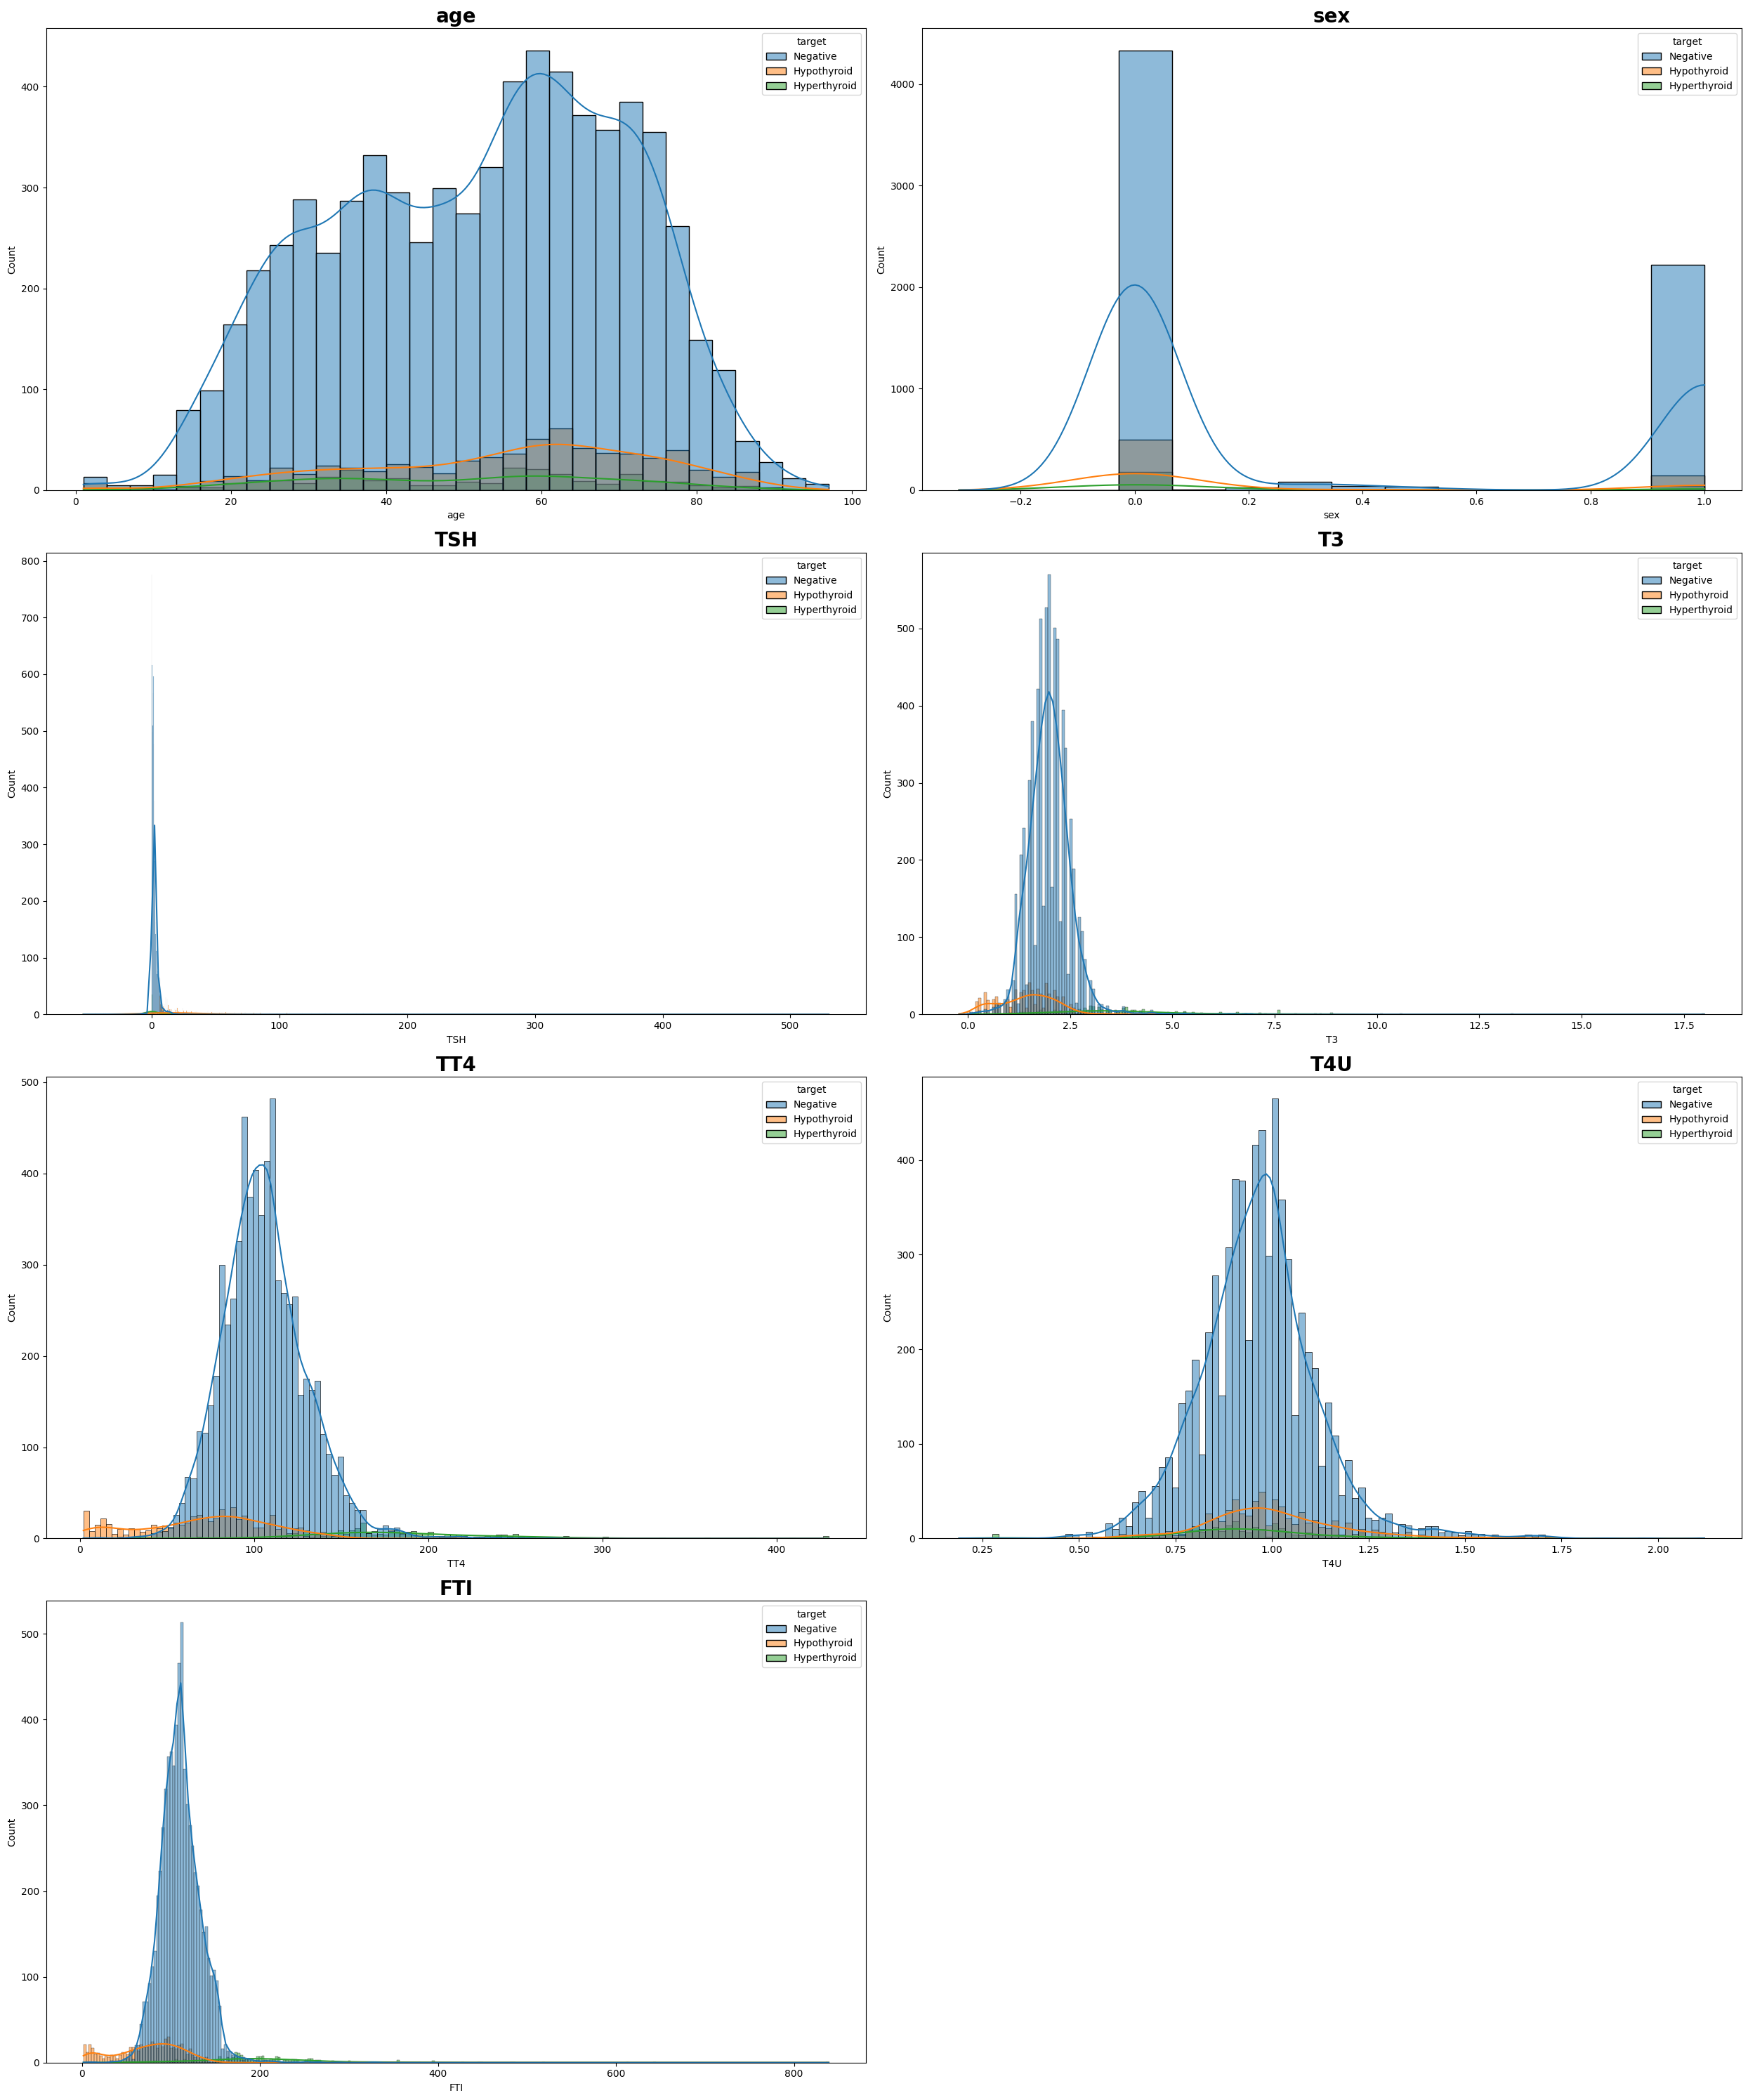

In [36]:
# Numerical columns
fig , ax = plt.subplots(ncols=2,nrows=4,figsize=(25,30))
ax = ax.flatten()
for a,i in enumerate(num_cols):
    sns.histplot(data=df,x=i,ax=ax[a],kde=True,hue="target")
    ax[a].set_title(i,size=20,weight="bold")
ax[-1].set_axis_off()
plt.tight_layout()

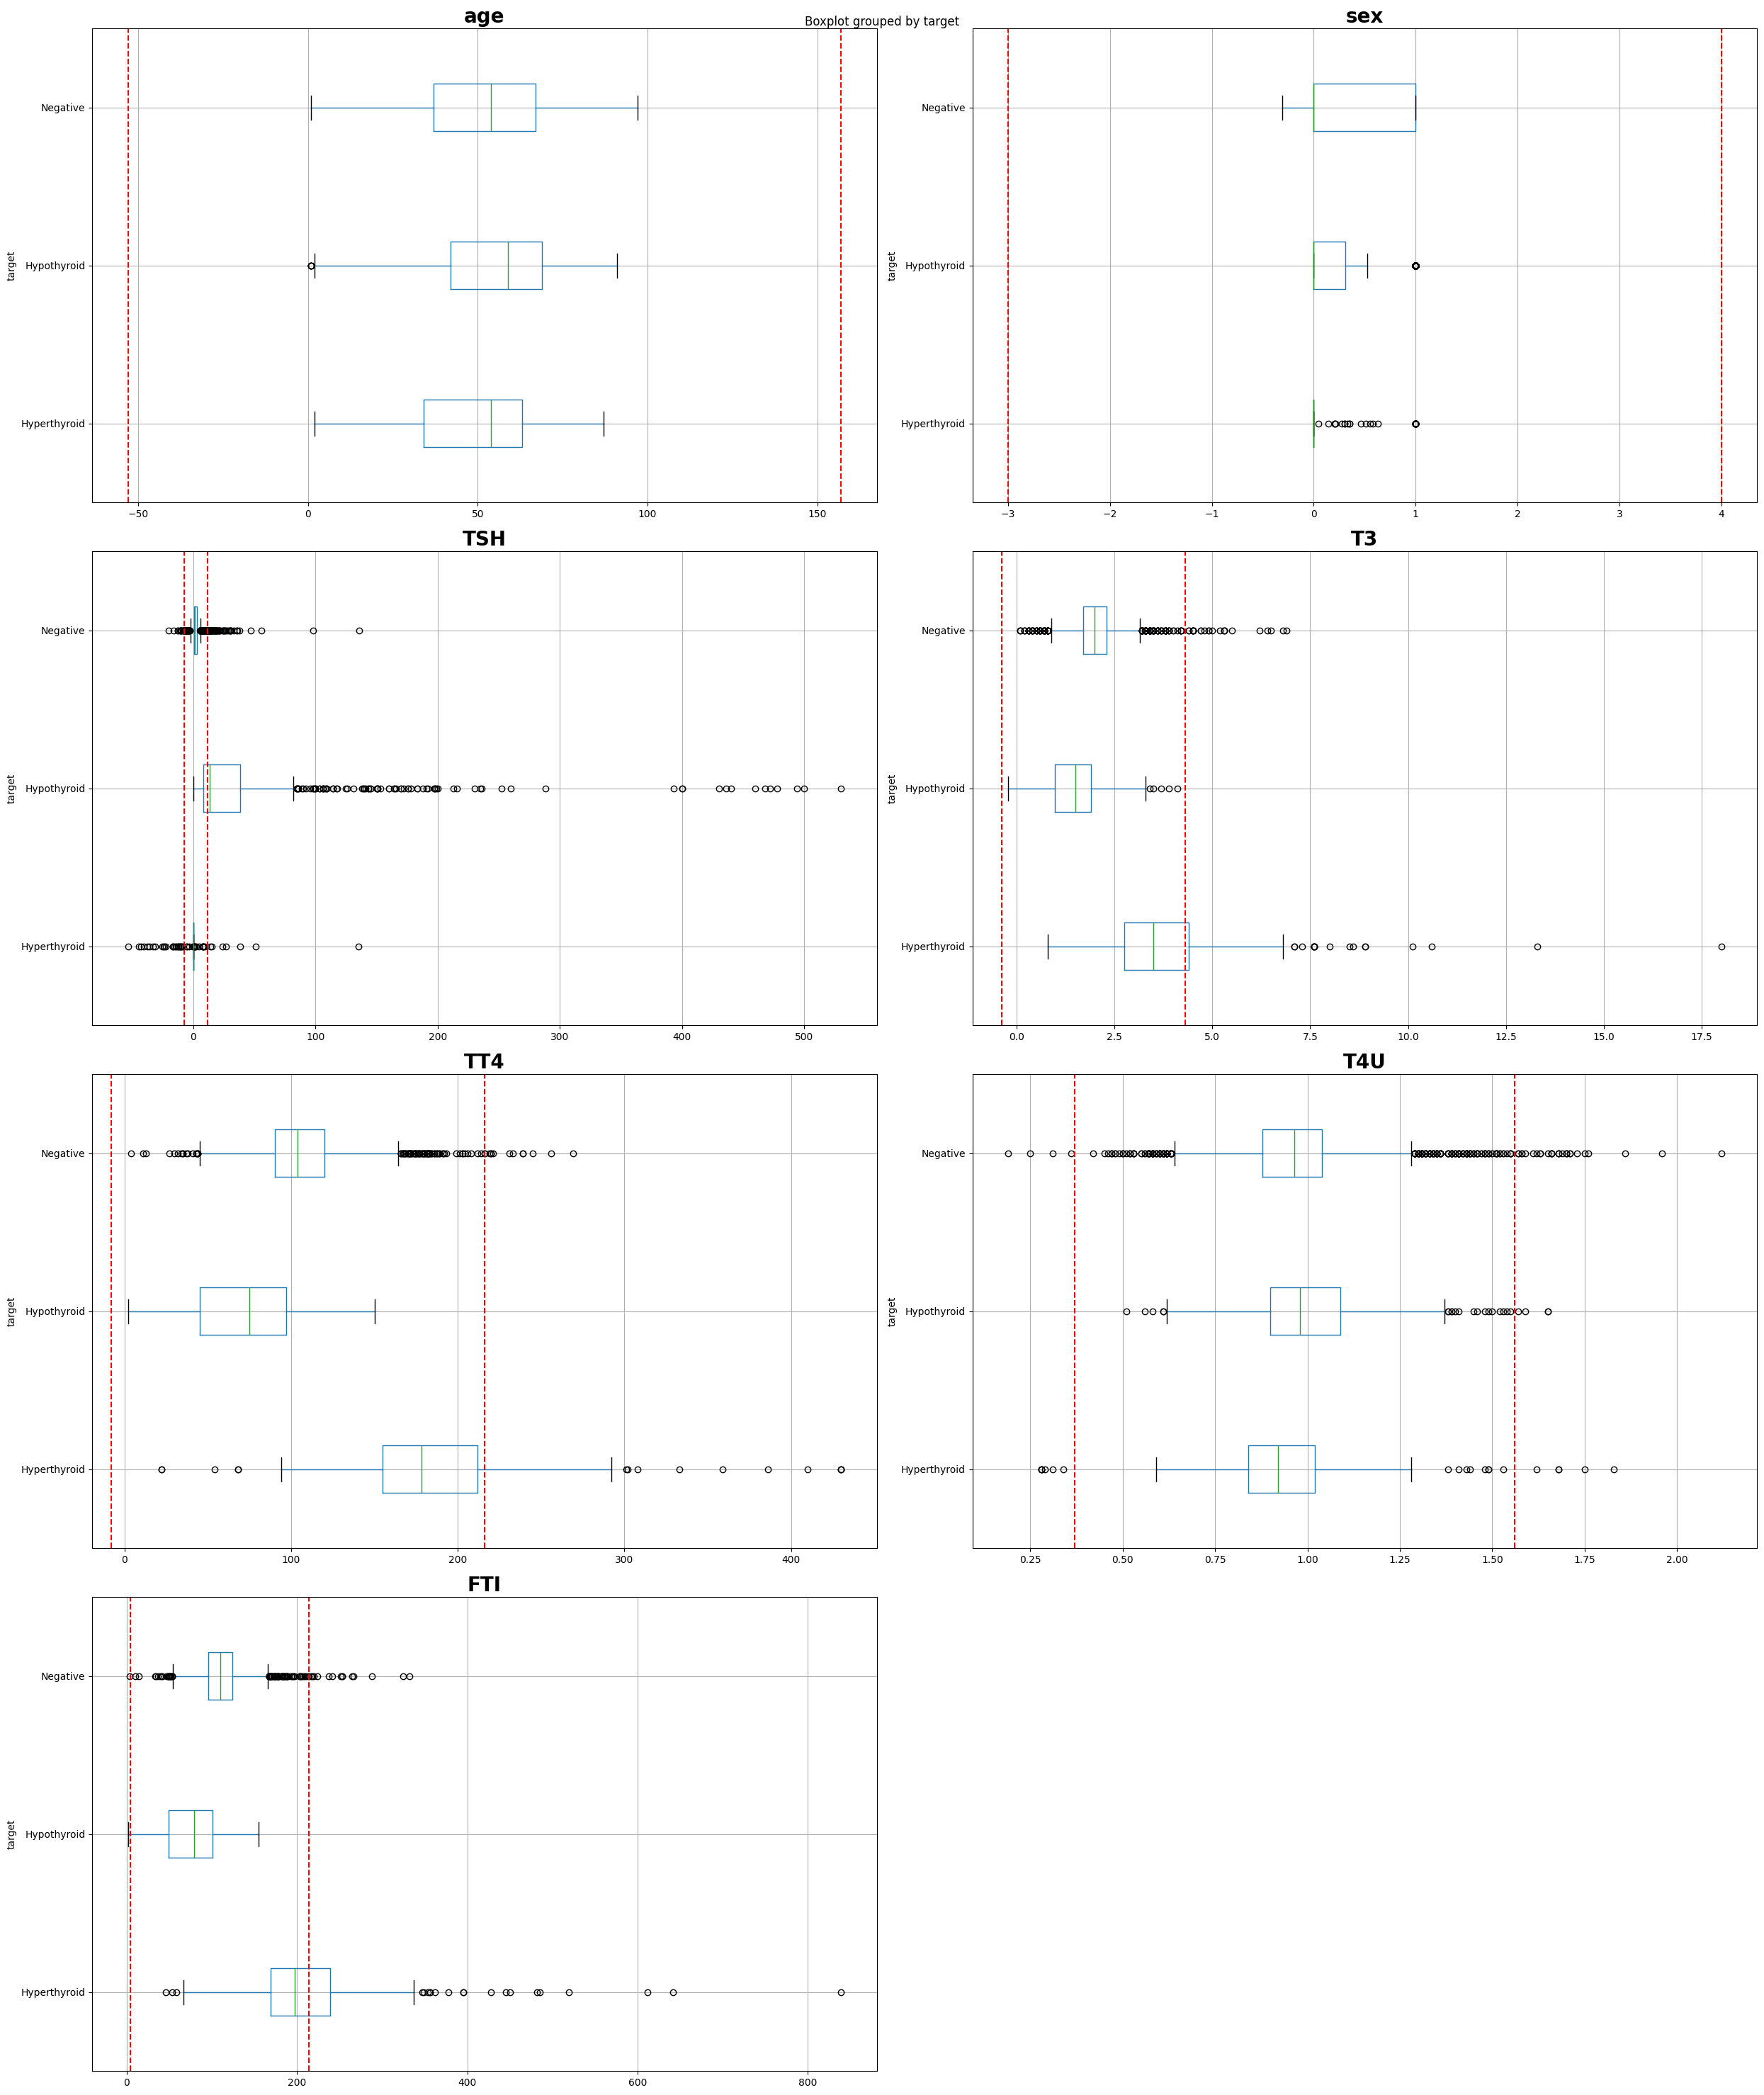

In [37]:
# Numerical columns
fig , ax = plt.subplots(ncols=2,nrows=4,figsize=(25,30))
ax = ax.flatten()
for a,i in enumerate(num_cols):
    q1 = df[i].quantile(0.25)
    q3 = df[i].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 3*iqr
    upper = q3 + 3*iqr
    df.boxplot(column=i,ax=ax[a],vert=False,by="target")
    ax[a].axvline(x=lower,color="r",linestyle="--")
    ax[a].axvline(x=upper,color="r",linestyle="--")
    ax[a].set_title(i,size=20,weight="bold")
ax[-1].set_axis_off()
plt.tight_layout()

In [38]:
# Outliers removal
# z = np.abs(zscore(df[num_cols]))
# df = df[(z<3).all(axis=1)]

In [39]:
df.shape

(7675, 22)

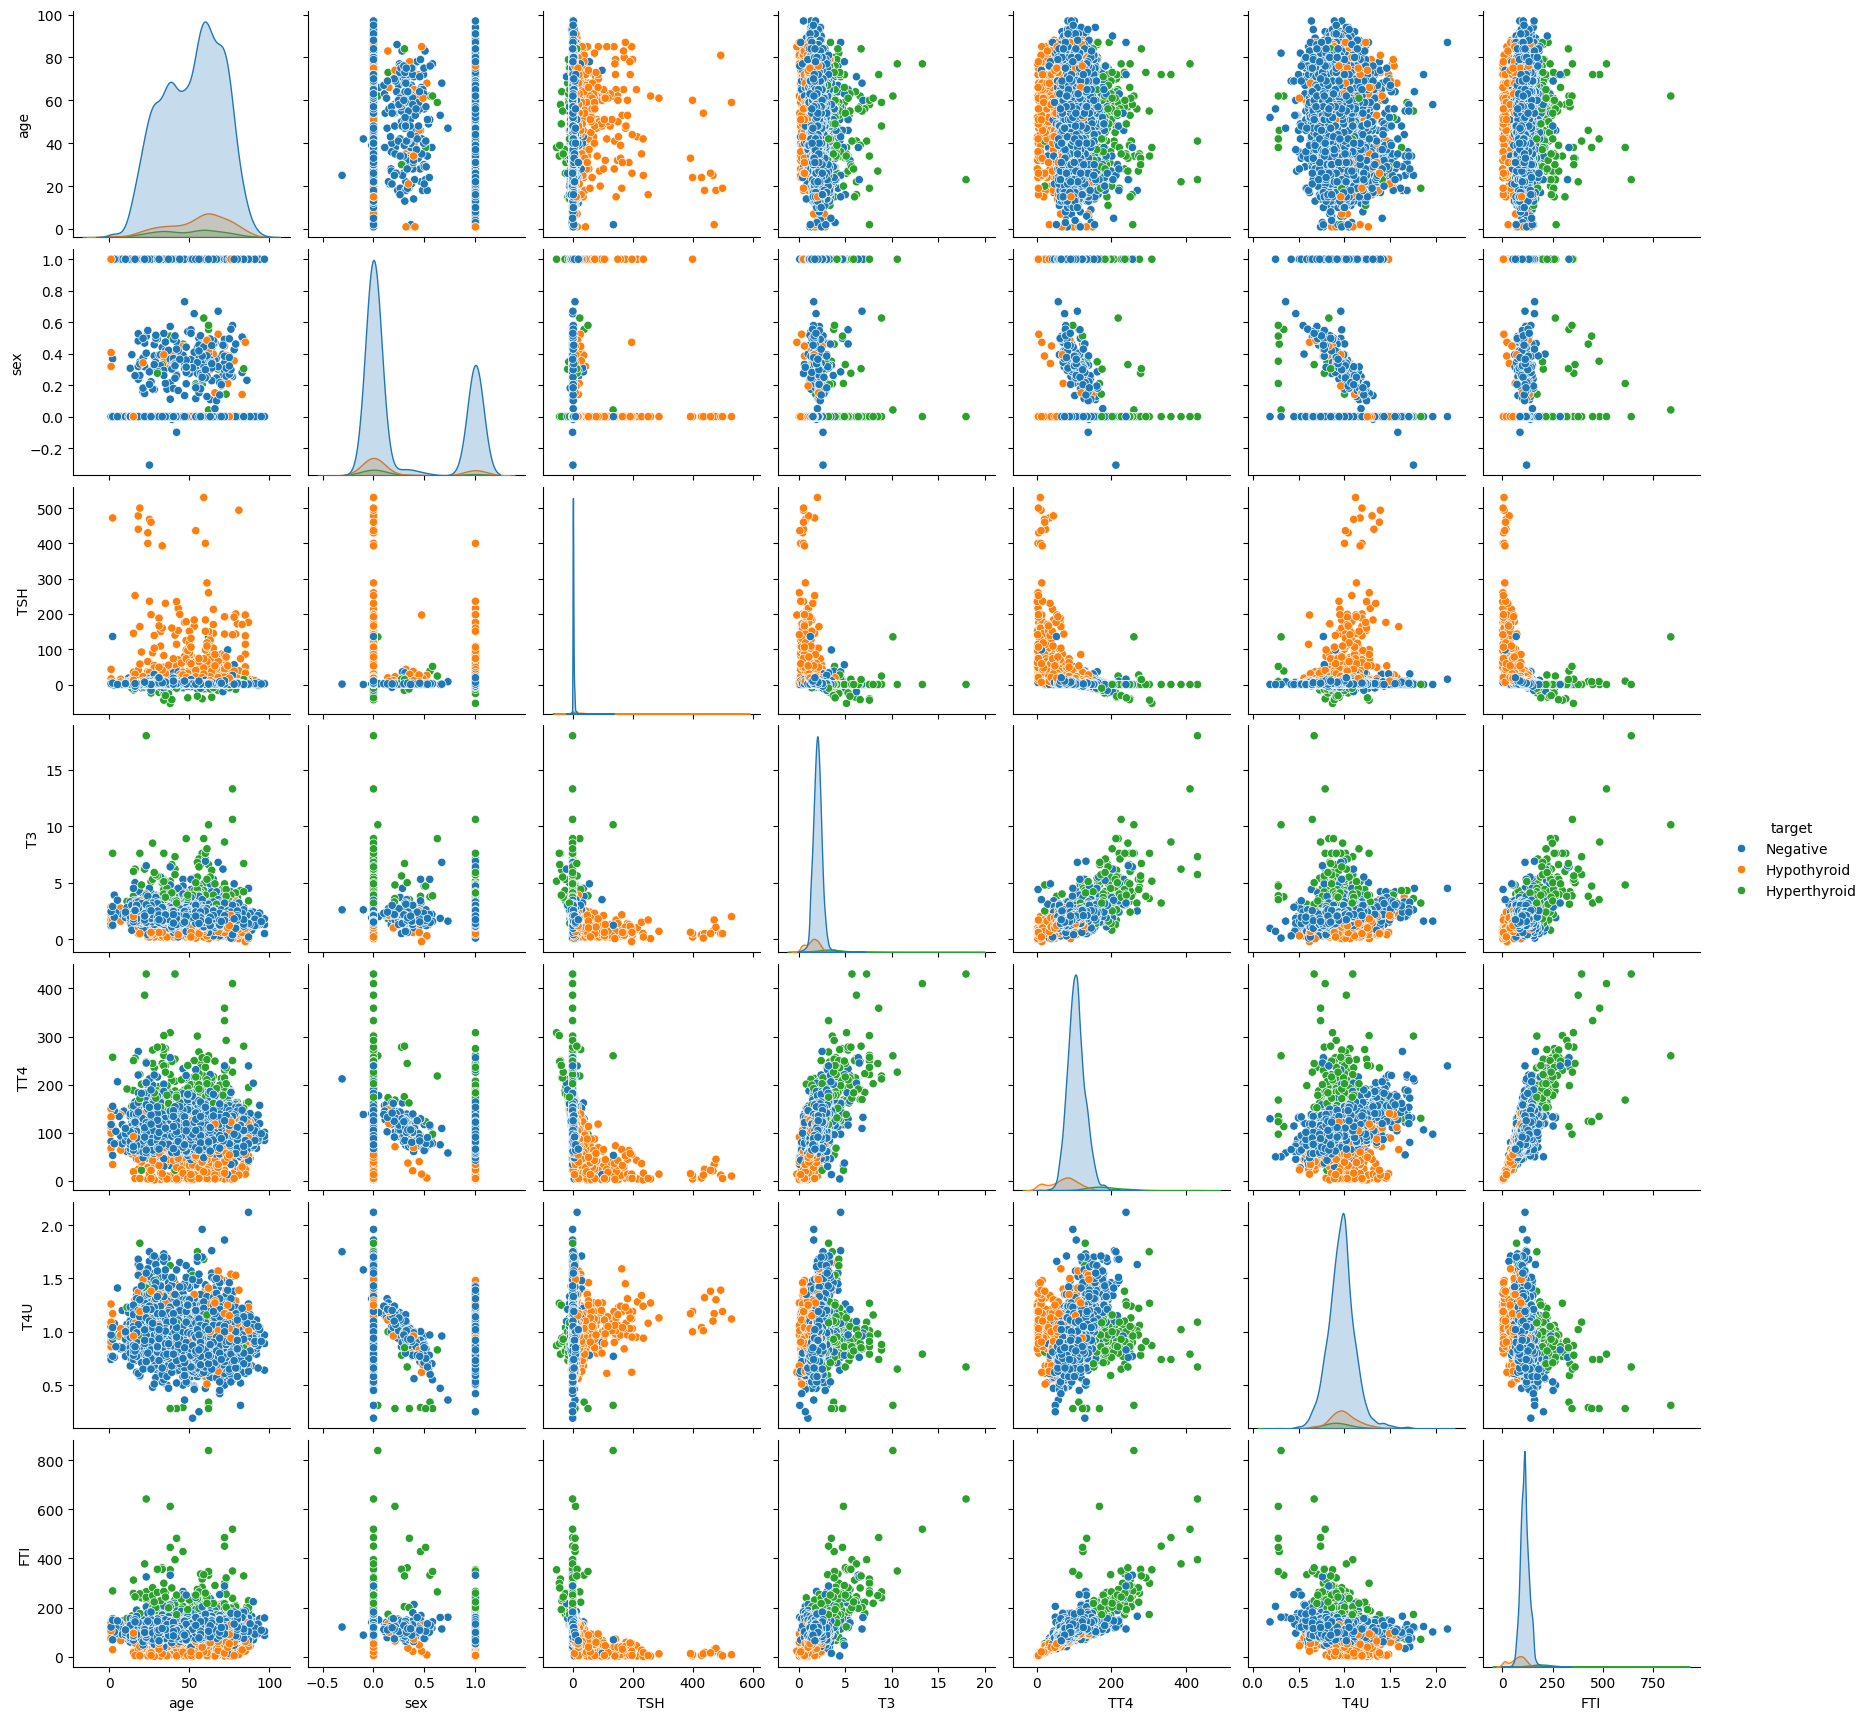

In [40]:
sns.pairplot(df,hue="target")

<Axes: >

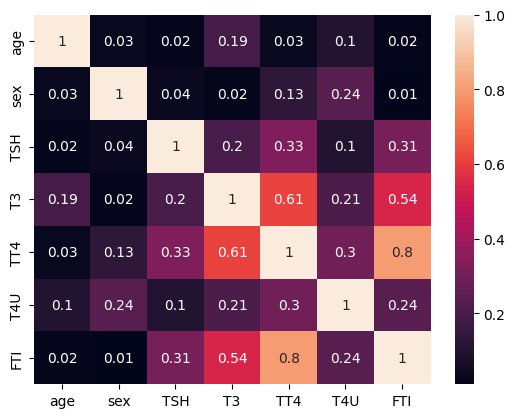

In [41]:
# Correlation
sns.heatmap(df[num_cols].corr().abs().round(2),annot=True)

In [42]:
# ! pip install dython

In [43]:
# import dython
# from dython.nominal import  associations

# associations(df,figsize=(20,20),nom_nom_assoc="theil")
# plt.show()

In [44]:
df = df.replace({"t":1,"f":0})

In [45]:
#
X = df.drop("target",axis=1)
y = df["target"]

In [46]:
resampler = SMOTETomek(random_state=42)
X_res , y_res = resampler.fit_resample(X,y)

In [47]:
# Data scaling and transformation
y_res.value_counts()

target
Hypothyroid     6760
Hyperthyroid    6741
Negative        6734
Name: count, dtype: int64

In [48]:
# Custom outlier remover for pipeline
# def CustomSampler_IQR (X, y):
    
#     features = X.columns
#     df = X.copy()
#     df['Outcome'] = y
    
#     indices = [x for x in df.index]    
#     out_indexlist = []
        
#     for col in features:
       
#         #Using nanpercentile instead of percentile because of nan values
#         Q1 = np.nanpercentile(df[col], 25.)
#         Q3 = np.nanpercentile(df[col], 75.)
        
#         cut_off = (Q3 - Q1) * 1.5
#         upper, lower = Q3 + cut_off, Q1 - cut_off
                
#         outliers_index = df[col][(df[col] < lower) | (df[col] > upper)].index.tolist()
#         outliers = df[col][(df[col] < lower) | (df[col] > upper)].values        
#         out_indexlist.extend(outliers_index)
        
#     #using set to remove duplicates
#     out_indexlist = list(set(out_indexlist))
    
#     clean_data = np.setdiff1d(indices,out_indexlist)

#     return X.loc[clean_data], y.loc[clean_data]

In [49]:
# Examples of Pipeline design with outlier removal 
# LR_Pipeline = Pipeline([('Outlier_removal', FunctionSampler(func=CustomSampler_IQR, validate = False))
#                         ,('Imputer', SimpleImputer(strategy = "median"))
#                         ,('LR',  LogisticRegression(C = 0.7, random_state = 42, max_iter = 1000))])


# KNN_Pipeline = Pipeline([('Outlier_removal', FunctionSampler(func=CustomSampler_IQR, validate = False))
#                         ,('Imputer',SimpleImputer(strategy = "median"))
#                         ,('KNN', KNeighborsClassifier(n_neighbors=7))])